# Tensorflow Demo: MNIST for Experts

https://github.com/ianlewis/tensorflow-examples

# Loading MNIST training data
The MNIST dataset comprises 60,000 training examples and 10,000 test examples of the handwritten digits 0–9, formatted as 28x28-pixel monochrome images.
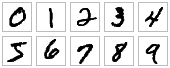

In [ ]:
# Import modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

## Tensorflow Placeholders

In [ ]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

## Weight & Biases Initialization

To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons." Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

In [ ]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

## Convolution & Pooling

TensorFlow also gives us a lot of flexibility in convolution and pooling operations. How do we handle the boundaries? What is our stride size? In this example, we're always going to choose the vanilla version. Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input.

In [ ]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

## First Convolutional Layer

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolutional will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [ ]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [ ]:
x_image = tf.reshape(x, [-1,28,28,1]) #[784,1] to [1, 28, 28, 1] NHCW

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.

In [ ]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [ ]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Densely Connected Layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [ ]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [ ]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## Readout Layer

Finally, we add a softmax layer, just like for the one layer softmax regression.

In [ ]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

## Train and Evaluate the Model

How well does this model do? To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above. The differences are that: we will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer; we will include the additional parameter keep_prob in feed_dict to control the dropout rate; and we will add logging to every 100th iteration in the training process.



In [ ]:
# initialize variables and session
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())

# Run mini-batch training on 50 elements 20000 times.
for i in range(2000):
    batch = mnist.train.next_batch(50)
    if i%20 == 0:
        # train_accuracy = accuracy.eval(feed_dict={
        #     x:batch[0], y_: batch[1], keep_prob: 1.0})
        train_accuracy = sess.run(accuracy, feed_dict={
             x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g" % (i, train_accuracy)) 
    # train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g" % sess.run(accuracy, feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

In [ ]:
for i in range(10):
    batch = mnist.train.next_batch(1)
    x_im, pred, actual = sess.run([x_image, tf.argmax(y_conv,1), tf.argmax(y_,1)],
                          feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
    plt.imshow(np.squeeze(x_im), cmap='gray')
    plt.show()
    print('Predicted:', str(pred[0]), 'Actual:', str(actual[0]))